# UK COVID-19 Case Fatality Rate (CFR) Analysis

This notebook analyzes the time-varying factual and counterfactual CFR for the United Kingdom using the proposed Bayesian semiparametric model (sCFR) and compares it against several benchmark models. This version includes both the start and end (lift) dates of major lockdowns as interventions.

## 1. Setup and Data Loading

In [1]:
import os
import pandas as pd
import numpy as np
import jax
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
from scipy.special import expit as sigmoid, logit

# Import necessary functions from the provided modules
import config
import data_generation
import model_fitting
import benchmarks

# --- Create Output Directory ---
OUTPUT_DIR = "./UK_analysis_outputs/"
os.makedirs(OUTPUT_DIR, exist_ok=True)
print(f"Outputs will be saved to: {OUTPUT_DIR}")

Outputs will be saved to: ./UK_analysis_outputs/


In [2]:
# --- Load and Prepare UK Data ---
df_who = pd.read_csv("./WHO-COVID-19-global-daily-data.csv", encoding='unicode_escape')
df_uk = df_who[df_who['Country'] == "United Kingdom of Great Britain and Northern Ireland"].copy()

# Define the analysis period: 2020-03-01 to 2021-12-31
df_uk['Date_reported'] = pd.to_datetime(df_uk['Date_reported'])
start_date = '2020-03-01'
end_date = '2021-12-31'
df_period = df_uk[(df_uk['Date_reported'] >= start_date) & (df_uk['Date_reported'] <= end_date)]

# Extract and smooth case and death counts (7-day moving average)
dates = df_period['Date_reported'].values
ct_raw = np.nan_to_num(df_period['New_cases'].values)
dt_raw = np.nan_to_num(df_period['New_deaths'].values)

ct = pd.Series(ct_raw).rolling(window=7, min_periods=1).mean().values.astype(int)
dt = pd.Series(dt_raw).rolling(window=7, min_periods=1).mean().values.astype(int)

N_obs = len(ct)
print(f"Data loaded for the period: {start_date} to {end_date} ({N_obs} days)")

Data loaded for the period: 2020-03-01 to 2021-12-31 (671 days)


## 2. Visualize Case and Death Counts

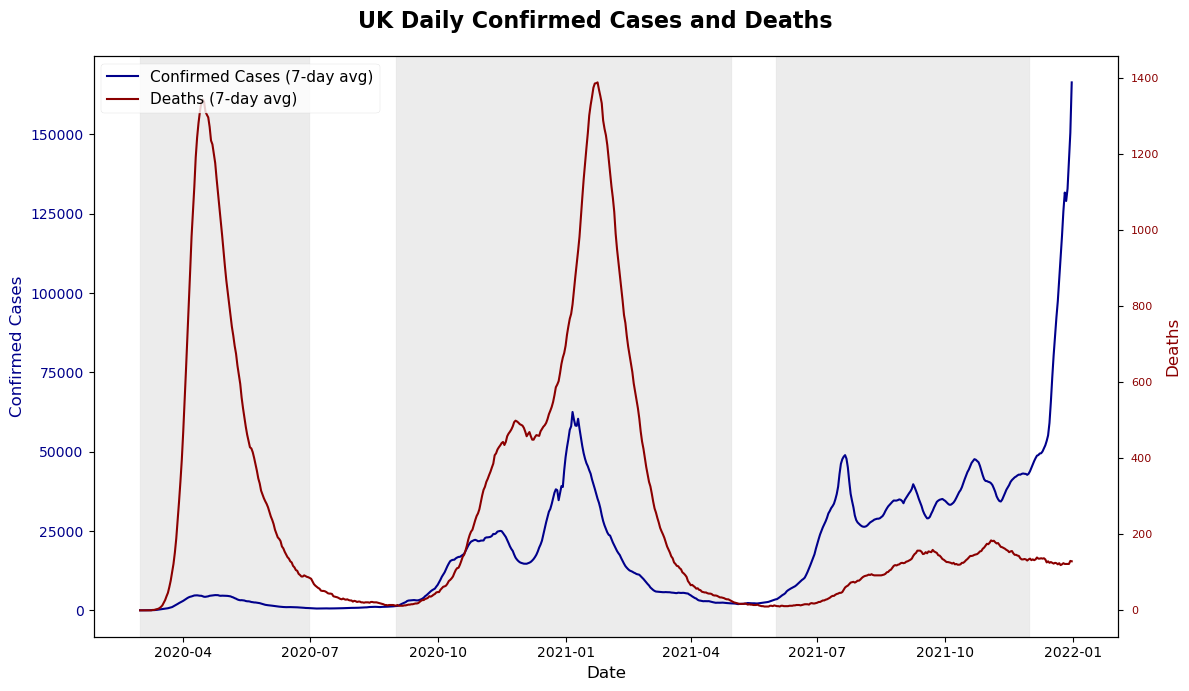

In [3]:
# --- Figure 1: Plot of Confirmed Cases and Deaths with Wave Annotations ---
fig, ax1 = plt.subplots(figsize=(12, 7))
plt.style.use('seaborn-v0_8-paper')

ax1.plot(dates, ct, color='darkblue', label='Confirmed Cases (7-day avg)', linewidth=1.5)
ax1.set_ylabel('Confirmed Cases', color='darkblue', fontsize=12)
ax1.set_xlabel('Date', fontsize=12)
ax1.tick_params(axis='y', labelcolor='darkblue')

ax2 = ax1.twinx()
ax2.plot(dates, dt, color='darkred', label='Deaths (7-day avg)', linewidth=1.5)
ax2.set_ylabel('Deaths', color='darkred', fontsize=12)
ax2.tick_params(axis='y', labelcolor='darkred')

# --- Add Wave Annotations ---
wave_periods = {
    'Wave 1': ('2020-03-01', '2020-07-01'),
    'Wave 2 ': ('2020-09-01', '2021-05-01'),
    'Wave 3 ': ('2021-06-01', '2021-12-01')
}

y_max_ax1 = ax1.get_ylim()[1]
for wave, (start, end) in wave_periods.items():
    ax1.axvspan(pd.to_datetime(start), pd.to_datetime(end), color='gray', alpha=0.15, zorder=0)
    text_x_pos = pd.to_datetime(start) + (pd.to_datetime(end) - pd.to_datetime(start))/2
    # ax1.text(text_x_pos, y_max_ax1 * 0.85, wave, ha='center', va='center', fontsize=13, style='italic')

fig.suptitle('UK Daily Confirmed Cases and Deaths', fontsize=16, weight='bold')
fig.tight_layout(rect=[0, 0, 1, 0.99])
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left', fontsize=11)

plt.savefig(os.path.join(OUTPUT_DIR, "uk_cases_and_deaths.pdf"), bbox_inches='tight')
plt.show()

## 3. Model Setup and Execution

Now, we set up the inputs for the models, including the delay distribution, B-spline basis, and intervention timings (both start and lift dates). Then we run the sCFR and benchmark models.

### UK Lockdown Timeline and Citations

The following dates for national lockdowns and subsequent easing in England are used in this analysis:

1.  **First National Lockdown:**
    * **Start:** 23 March 2020
    * **Lift (major easing):** 15 June 2020 (non-essential retail reopens)

2.  **Second National Lockdown:**
    * **Start:** 5 November 2020
    * **Lift:** 2 December 2020 (return to tiered system)

3.  **Third National Lockdown:**
    * **Start:** 6 January 2021
    * **Lift (major easing):** 12 April 2021 (non-essential retail and outdoor hospitality reopen)

**Citations (BibTeX Format):**
```bibtex
@misc{IfG_LockdownTimeline,
  author = {{Institute for Government}},
  title = {Timeline of UK government coronavirus lockdowns and restrictions},
  year = {2022},
  url = {https://www.instituteforgovernment.org.uk/data-visualisation/timeline-coronavirus-lockdowns},
  note = {Accessed: 2025-07-27}
}
```

In [4]:
# --- Define Intervention Times for UK Lockdowns (Start and Lift) ---
intervention_dates = [
    '2020-03-23', # Lockdown 1 Start
    '2020-06-15', # Lockdown 1 Lift
    '2020-11-05', # Lockdown 2 Start
    '2020-12-02', # Lockdown 2 Lift
    '2021-01-06', # Lockdown 3 Start
    '2021-04-12'  # Lockdown 3 Lift
]
intervention_times_abs = [(pd.to_datetime(d) - pd.to_datetime(start_date)).days for d in intervention_dates]
# Intervention signs: negative for lockdowns (start), positive for lifting restrictions
intervention_signs = np.array([-1, 1, -1, 1, -1, 1]) 
K_interventions = len(intervention_times_abs)

print(f"Interventions defined at days: {intervention_times_abs}")

# --- Prepare Data Dictionary for Models ---
N_SPLINE_KNOTS_J = 20
config.USE_RANDOM_EFFECT = True
f_s = data_generation.generate_delay_distribution(N_obs, config.F_MEAN, config.F_SHAPE)
Q_matrix = data_generation.construct_Q_matrix(ct, f_s, N_obs)
Bm_matrix = data_generation.generate_bspline_basis(N_obs, N_SPLINE_KNOTS_J, config.SPLINE_ORDER)
Z_input_matrix = data_generation.generate_intervention_input_matrix(
    np.arange(N_obs), intervention_times_abs, K_interventions
)

sim_data_dict = {
    "c_t": ct, "d_t": dt, "f_s_true": f_s, "Q_true": Q_matrix, 
    "Bm_true": Bm_matrix, "Z_input_true": Z_input_matrix,
    "beta_signs_true": intervention_signs, "N_obs": N_obs,
    "K_spline_obs": N_SPLINE_KNOTS_J,
    "num_interventions_true_K": K_interventions,
    "true_intervention_times_0_abs": intervention_times_abs
}

Interventions defined at days: [22, 106, 249, 276, 311, 407]


In [5]:
# --- Run sCFR Model ---
print("Fitting the proposed sCFR model...")
jax_key = jax.random.PRNGKey(config.GLOBAL_BASE_SEED)
posterior_samples, _ = model_fitting.fit_proposed_model(sim_data_dict, jax_key)
print("sCFR model fitting complete.")

Fitting the proposed sCFR model...
sCFR model fitting complete.


In [6]:
# --- Run Benchmark Models ---
print("Running benchmark models...")
benchmark_r_t_estimates = {
    "cCFR_cumulative": benchmarks.calculate_crude_cfr(sim_data_dict["d_t"], sim_data_dict["c_t"], cumulative=True),
    "aCFR_cumulative": benchmarks.calculate_nishiura_cfr_cumulative(sim_data_dict["d_t"], sim_data_dict["c_t"], sim_data_dict["f_s_true"])
}
benchmark_cis = benchmarks.calculate_benchmark_cis_with_bayesian(sim_data_dict["d_t"], sim_data_dict["c_t"], sim_data_dict["f_s_true"])
its_results = benchmarks.calculate_its_with_penalized_mle(
    d_t=sim_data_dict["d_t"], c_t=sim_data_dict["c_t"], 
    f_s=sim_data_dict["f_s_true"],
    Bm=sim_data_dict["Bm_true"],
    intervention_times_abs=sim_data_dict["true_intervention_times_0_abs"],
    intervention_signs=sim_data_dict["beta_signs_true"]
)
benchmark_outputs = {**benchmark_r_t_estimates, **benchmark_cis, **its_results}
print("Benchmark models complete.")

Running benchmark models...
Benchmark models complete.


## 4. Visualize CFR Estimations

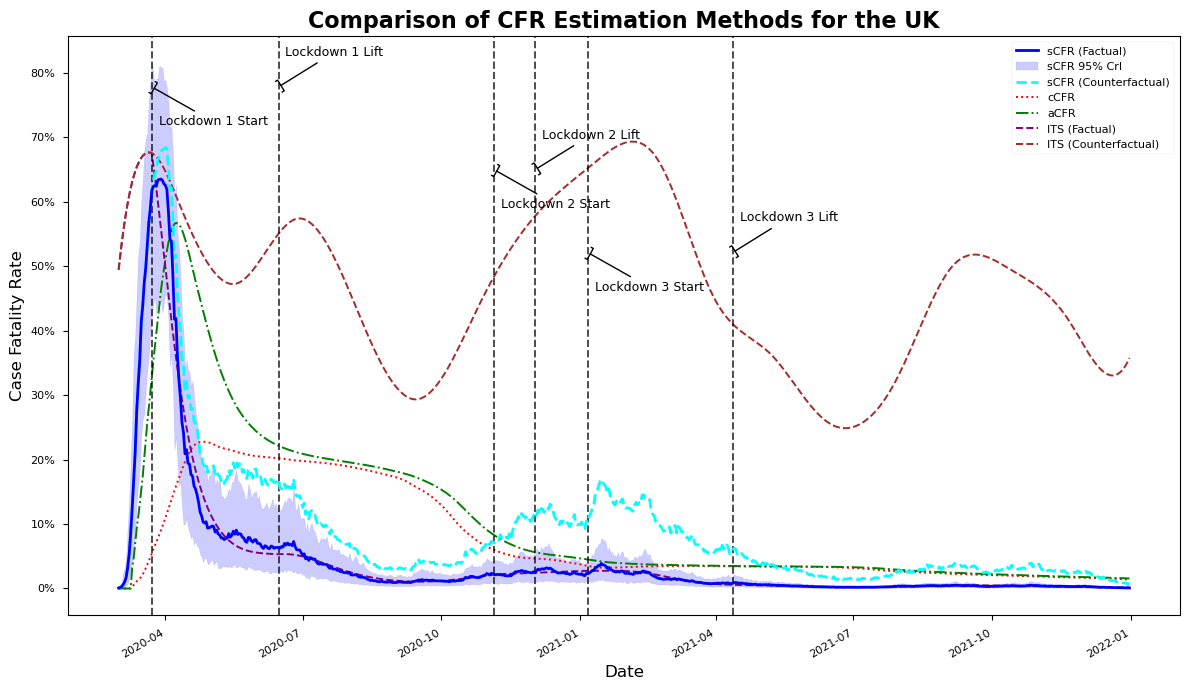

In [9]:
# --- Figure 2: Plot of Factual and Counterfactual CFR Estimates with Improved Annotations ---
fig, ax = plt.subplots(figsize=(12, 7))
plt.style.use('seaborn-v0_8-paper')

# --- Process sCFR results ---
p_mean = np.mean(posterior_samples['p'], axis=0)
p_lower, p_upper = np.percentile(posterior_samples['p'], [2.5, 97.5], axis=0)
p_cf_mean = np.mean(posterior_samples['p_cf'], axis=0)

# --- Plot sCFR Factual ---
ax.plot(dates, p_mean, label='sCFR (Factual)', color='blue', linewidth=2.0, zorder=5)
ax.fill_between(dates, p_lower, p_upper, color='blue', alpha=0.2, label='sCFR 95% CrI')

# --- Plot sCFR Counterfactual ---
ax.plot(dates, p_cf_mean, label='sCFR (Counterfactual)', color='cyan', linestyle='--', linewidth=2.0, zorder=4)

# --- Plot Benchmarks ---
ax.plot(dates, benchmark_outputs['cCFR_cumulative'], label='cCFR', color='red', linestyle=':')
ax.plot(dates, benchmark_outputs['aCFR_cumulative'], label='aCFR', color='green', linestyle='-.')
ax.plot(dates, benchmark_outputs['its_factual_mean'], label='ITS (Factual)', color='purple', linestyle='--')
ax.plot(dates, benchmark_outputs['its_counterfactual_mean'], label='ITS (Counterfactual)', color='brown', linestyle='--')

# --- Add Intervention Lines and Annotations (Improved Logic) ---
intervention_labels = [
    'Lockdown 1 Start', 'Lockdown 1 Lift',
    'Lockdown 2 Start', 'Lockdown 2 Lift',
    'Lockdown 3 Start', 'Lockdown 3 Lift'
]

# Stagger annotation heights to prevent overlap
y_max = ax.get_ylim()[1]
annotation_y_levels = [y_max * 0.85, y_max * 0.7, y_max * 0.55]
text_y_offsets = [-25, 25, -25, 25, -25, 25] # Alternate text position

for i, t_int in enumerate(intervention_times_abs):
    date = dates[t_int]
    label = intervention_labels[i]
    y_level = annotation_y_levels[i // 2] + 0.05 # Use the same height for each start/lift pair
    y_offset = text_y_offsets[i]
    
    ax.axvline(x=date, color='black', linestyle='--', alpha=0.7)
    ax.annotate(label, xy=(date, y_level), xytext=(5, y_offset), 
                textcoords='offset points', ha='left', va='center', fontsize=9, 
                arrowprops=dict(arrowstyle='-[, widthB=0.5, lengthB=0.2', lw=1.0))

# --- Formatting ---
ax.set_title('Comparison of CFR Estimation Methods for the UK', fontsize=16, weight='bold')
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Case Fatality Rate', fontsize=12)
ax.yaxis.set_major_formatter(mticker.PercentFormatter(xmax=1.0))
ax.legend(loc='upper right')
plt.xticks(rotation=30, ha='right')
plt.tight_layout()

plt.savefig(os.path.join(OUTPUT_DIR, "uk_cfr_comparison.pdf"), bbox_inches='tight')
plt.show()